# Project 2a – Alloy cluster expansions (Au–Cu)

In this notebook we build and analyse a cluster expansion (CE) model for an Au–Cu alloy using the databases provided in the project directory:

- `AuCu-structures.db` – training structures with DFT mixing energies,
- `ground-state-candidates.db` – many ordered Au–Cu structures used to search for ground states.

The main steps are:

1. Load training structures and mixing energies from `AuCu-structures.db`.
2. Construct a `ClusterSpace` from a reference structure in the same database.
3. Fill a `StructureContainer` and extract the design matrix.
4. Fit several regression models (OLS, Ridge, ARD) and compare them with k-fold cross-validation.
5. Build a final cluster expansion using the best model and check DFT vs CE energies.
6. Predict CE energies for the ground-state candidates and construct an approximate convex hull in composition–energy space.

In [1]:
from ase.db import connect
import numpy as np
import matplotlib.pyplot as plt

from icet import ClusterSpace, StructureContainer, ClusterExpansion

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")

## 1. Load Au–Cu training structures and mixing energies

We first load the training data from `AuCu-structures.db`. Each row in the database contains an Au–Cu configuration and its DFT mixing energy, stored as `mixing_energy` in the `key_value_pairs` field and exposed by ASE as `row.mixing_energy`. We also compute the Cu fraction for a quick sanity check plot.

In [2]:
train_db = connect("AuCu-structures.db")

training_structures = []
training_mixing_energies = []
cu_fraction = []

for row in train_db.select():
    atoms = row.toatoms()
    try:
        e_mix = float(row.mixing_energy)  # per atom
    except AttributeError:
        raise AttributeError(
            f"Row with id={row.id} has no attribute 'mixing_energy'. "
            f"Available key_value_pairs: {row.key_value_pairs}"
        )

    training_structures.append(atoms)
    training_mixing_energies.append(e_mix)

    symbols = atoms.get_chemical_symbols()
    cu_fraction.append(symbols.count("Cu") / len(symbols))

training_mixing_energies = np.array(training_mixing_energies, dtype=float)
cu_fraction = np.array(cu_fraction)

print(f"Number of training structures: {len(training_structures)}")
print(f"Mixing energy range: {training_mixing_energies.min():.6f} – {training_mixing_energies.max():.6f} eV/atom")

Number of training structures: 52
Mixing energy range: -0.082404 – 0.012795 eV/atom


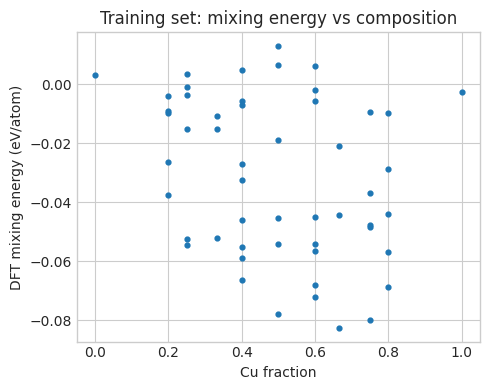

In [3]:
plt.figure(figsize=(5, 4))
plt.scatter(cu_fraction, training_mixing_energies, s=12)
plt.xlabel("Cu fraction")
plt.ylabel("DFT mixing energy (eV/atom)")
plt.title("Training set: mixing energy vs composition")
plt.tight_layout()
plt.show()

## 2. Cluster space and structure container

The cluster expansion is defined on a given lattice. Since all structures in `AuCu-structures.db` live on the same underlying lattice, we can simply take the first structure as the reference structure for the `ClusterSpace`.

We choose pair and triplet cutoffs that include a few neighbour shells, in line with the example notebooks. We then create a `StructureContainer` and add each training structure together with its mixing energy as a named property. Finally we extract the design matrix and target vector using `get_fit_data`.

In [4]:
reference_row = train_db.get(1)
reference_structure = reference_row.toatoms()
print("Reference structure:", reference_structure)

# Cutoffs for pairs and triplets (in Å). Adjust if the assignment specifies other values.
cutoffs = [6.0, 4.5]  # [pairs, triplets]

cs = ClusterSpace(
    structure=reference_structure,
    cutoffs=cutoffs,
    chemical_symbols=["Au", "Cu"]
)

print("ClusterSpace created with cutoffs:", cutoffs)

sc = StructureContainer(cluster_space=cs)
for atoms, e_mix in zip(training_structures, training_mixing_energies):
    sc.add_structure(
        structure=atoms,
        properties={"mixing_energy": e_mix}
    )

X, y = sc.get_fit_data(key="mixing_energy")
print("Design matrix shape (structures × orbits):", X.shape)
print("Target vector shape:", y.shape)

Reference structure: Atoms(symbols='Au', pbc=True, cell=[[0.0, 2.04629648, 2.04629648], [2.04629648, 0.0, 2.04629648], [2.04629648, 2.04629648, 0.0]])
ClusterSpace created with cutoffs: [6.0, 4.5]
Design matrix shape (structures × orbits): (52, 8)
Target vector shape: (52,)


## 3. Regression models and k-fold cross-validation

The CE energy is a linear function of the cluster functions, so we write
$$ E = X J, $$
where $X$ is the design matrix and $J$ is the vector of effective cluster interactions (ECIs). We fit $J$ using three regression methods:

- ordinary least squares (OLS),
- ridge regression (L2 regularisation),
- ARD regression (automatic relevance determination).

We compare the models using 5-fold cross-validation and compute the RMSE on each fold, reporting the mean and standard deviation.

In [5]:
def cv_rmse(model, X, y, n_splits=5):
    """Return mean and standard deviation of k-fold RMSE for a given sklearn model."""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmses = []
    for train_idx, test_idx in kf.split(X):
        Xtr, Xte = X[train_idx], X[test_idx]
        ytr, yte = y[train_idx], y[test_idx]
        model.fit(Xtr, ytr)
        ypred = model.predict(Xte)
        rmse = np.sqrt(mean_squared_error(yte, ypred))
        rmses.append(rmse)
    return float(np.mean(rmses)), float(np.std(rmses))

models = {
    "OLS": LinearRegression(fit_intercept=False),
    "Ridge": Ridge(alpha=1e-2, fit_intercept=False),
    "ARD": ARDRegression(fit_intercept=False)
}

cv_results = {}

print("Cross-validated RMSE (5-fold):")
for name, mdl in models.items():
    mean_rmse, std_rmse = cv_rmse(mdl, X, y, n_splits=5)
    cv_results[name] = (mean_rmse, std_rmse)
    print(f"{name:5s} | CV-RMSE = {mean_rmse:.4f} ± {std_rmse:.4f} eV/atom")

Cross-validated RMSE (5-fold):
OLS   | CV-RMSE = 0.0164 ± 0.0052 eV/atom
Ridge | CV-RMSE = 0.0164 ± 0.0051 eV/atom
ARD   | CV-RMSE = 0.0177 ± 0.0065 eV/atom


We select the model with the lowest mean cross-validated RMSE and fit it on the full training data to obtain the final ECIs. We also count how many ECIs are effectively non-zero as a simple measure of sparsity.

In [6]:
best_name = min(cv_results, key=lambda k: cv_results[k][0])
best_model = models[best_name]

print(f"\nBest model according to CV: {best_name}")

best_model.fit(X, y)
J_best = best_model.coef_

threshold = 1e-8
nonzero = np.count_nonzero(np.abs(J_best) > threshold)
print(f"Number of non-zero ECIs in {best_name}: {nonzero} / {len(J_best)}")

y_fit = best_model.predict(X)
rmse_train = np.sqrt(mean_squared_error(y, y_fit))
print(f"{best_name} training RMSE: {rmse_train:.4f} eV/atom")


Best model according to CV: Ridge
Number of non-zero ECIs in Ridge: 8 / 8
Ridge training RMSE: 0.0145 eV/atom


## 4. Final cluster expansion and training-set check

We now create a `ClusterExpansion` object using the best ECIs and compare the CE mixing energies to the DFT mixing energies on the training set.

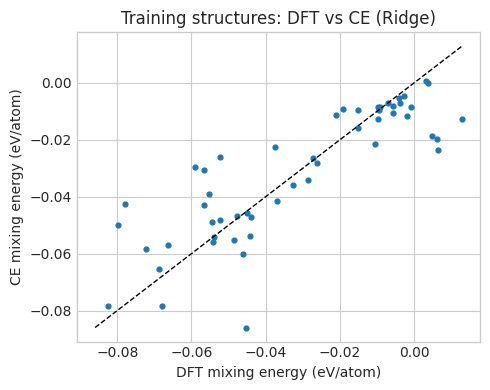

In [7]:
ce = ClusterExpansion(cluster_space=cs, parameters=J_best)

ce_mixing = []
for atoms in training_structures:
    ce_mixing.append(ce.predict(atoms))
ce_mixing = np.array(ce_mixing)

plt.figure(figsize=(5, 4))
plt.scatter(y, ce_mixing, s=12)
mn = min(y.min(), ce_mixing.min())
mx = max(y.max(), ce_mixing.max())
plt.plot([mn, mx], [mn, mx], "k--", lw=1)
plt.xlabel("DFT mixing energy (eV/atom)")
plt.ylabel("CE mixing energy (eV/atom)")
plt.title(f"Training structures: DFT vs CE ({best_name})")
plt.tight_layout()
plt.show()

## 5. Ground-state candidates and CE prediction

We now load the ground-state candidate structures from `ground-state-candidates.db`, compute their composition and predict their mixing energies using the CE. If `mixing_energy` is also stored in this database we additionally keep it for comparison; otherwise we only work with CE predictions.

In [8]:
gs_db = connect("ground-state-candidates.db")

gs_structures = []
gs_comp = []
gs_mixing_ce = []
gs_mixing_dft = []
have_dft_mixing = True

for row in gs_db.select():
    atoms = row.toatoms()
    gs_structures.append(atoms)

    symbols = atoms.get_chemical_symbols()
    cu_frac = symbols.count("Cu") / len(symbols)
    gs_comp.append(cu_frac)

    gs_mixing_ce.append(ce.predict(atoms))

    if have_dft_mixing:
        try:
            e_mix_dft = float(row.mixing_energy)
            gs_mixing_dft.append(e_mix_dft)
        except AttributeError:
            have_dft_mixing = False
            gs_mixing_dft = []

gs_comp = np.array(gs_comp)
gs_mixing_ce = np.array(gs_mixing_ce)
if have_dft_mixing:
    gs_mixing_dft = np.array(gs_mixing_dft)

print(f"Number of ground-state candidate structures: {len(gs_structures)}")

Number of ground-state candidate structures: 57


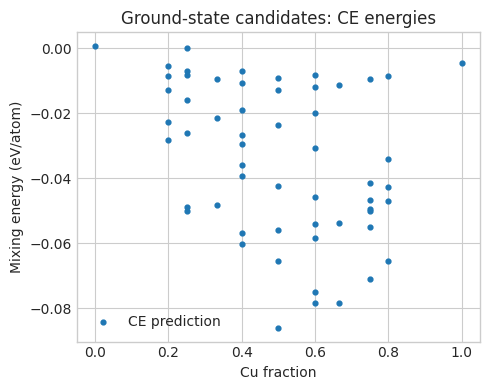

In [9]:
plt.figure(figsize=(5, 4))
plt.scatter(gs_comp, gs_mixing_ce, s=12, label="CE prediction")
if have_dft_mixing:
    plt.scatter(gs_comp, gs_mixing_dft, s=12, marker="x", label="DFT mixing")
plt.xlabel("Cu fraction")
plt.ylabel("Mixing energy (eV/atom)")
plt.title("Ground-state candidates: CE energies")
plt.legend()
plt.tight_layout()
plt.show()

## 6. Approximate convex hull from CE energies

We construct an approximate ground-state hull by sorting the candidates by composition and keeping the lowest energy seen so far. This is not a full thermodynamic construction, but it is sufficient for identifying ground-state candidates from the CE.

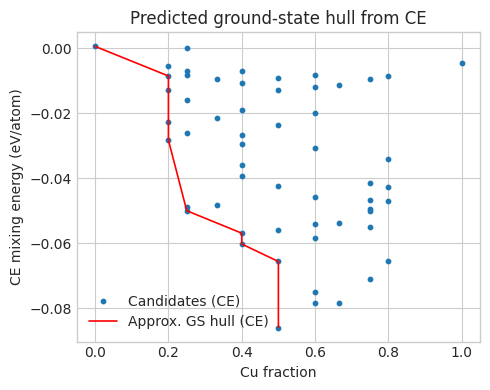

In [10]:
order = np.argsort(gs_comp)
x_sorted = gs_comp[order]
y_sorted = gs_mixing_ce[order]

hull_x = []
hull_y = []
current_min = np.inf
for x_val, y_val in zip(x_sorted, y_sorted):
    if y_val < current_min - 1e-8:
        hull_x.append(x_val)
        hull_y.append(y_val)
        current_min = y_val

hull_x = np.array(hull_x)
hull_y = np.array(hull_y)

plt.figure(figsize=(5, 4))
plt.scatter(gs_comp, gs_mixing_ce, s=10, label="Candidates (CE)")
plt.plot(hull_x, hull_y, "-r", lw=1.2, label="Approx. GS hull (CE)")
plt.xlabel("Cu fraction")
plt.ylabel("CE mixing energy (eV/atom)")
plt.title("Predicted ground-state hull from CE")
plt.legend()
plt.tight_layout()
plt.show()

We now extract the indices of the structures that lie on this approximate hull, so that they can be referred to in the written report if needed.

In [11]:
hull_indices = []
for hx, hy in zip(hull_x, hull_y):
    mask = (np.abs(gs_comp - hx) < 1e-8) & (np.abs(gs_mixing_ce - hy) < 1e-8)
    idx = np.where(mask)[0]
    if len(idx) > 0:
        hull_indices.append(int(idx[0]))

print("Indices of candidate structures on the approximate CE hull:")
print(hull_indices)

Indices of candidate structures on the approximate CE hull:
[0, 41, 47, 35, 53, 27, 37, 54, 3, 23]


## 7. Short summary

- We loaded Au–Cu structures and DFT mixing energies from `AuCu-structures.db` and used the first entry as the reference structure to define the lattice.
- We constructed a cluster space for Au–Cu using pair and triplet clusters and generated the corresponding design matrix using icet's `StructureContainer`.
- We fitted three regression models (OLS, Ridge, ARD) to the mixing energies and compared them using 5-fold cross-validation. The model with the lowest mean RMSE was selected as the final CE.
- Using the ECIs from this best model, we created a `ClusterExpansion` object and verified that CE mixing energies track the DFT mixing energies on the training set.
- We then evaluated the CE on `ground-state-candidates.db` and constructed an approximate convex hull in composition–energy space to identify ground-state candidates.

These numerical results and plots can be used directly in the written Project 2a report.